In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arch
import scipy as sp  
import scipy.stats as scs
from sklearn.neighbors import KernelDensity
from arch import arch_model

In [23]:
burn          = '2018-03-31'

bullish_start = '2019-03-31'

calm_start    = '2019-10-01'

covid_start   = '2020-02-01'

scenarios     = {burn:'2018-03-31', bullish_start : '2019-03-31', calm_start: '2019-10-01', covid_start: '2020-02-01'}


In [24]:
sigmas      = pd.read_csv('parameters.csv')['SIGMA']

btc         = pd.read_csv('BTCUSDT.csv')

btc_bullish = btc[(btc['Date'] >= burn) & (btc['Date'] < calm_start)]

rt_bullish  = btc[(btc['Date'] >= bullish_start) & (btc['Date'] < calm_start)]

btc         = btc_bullish

rt          = rt_bullish


btc.Date = pd.to_datetime(btc.Date)
btc.set_index('Date',inplace=True)


Text(0, 0.5, 'BTC price')

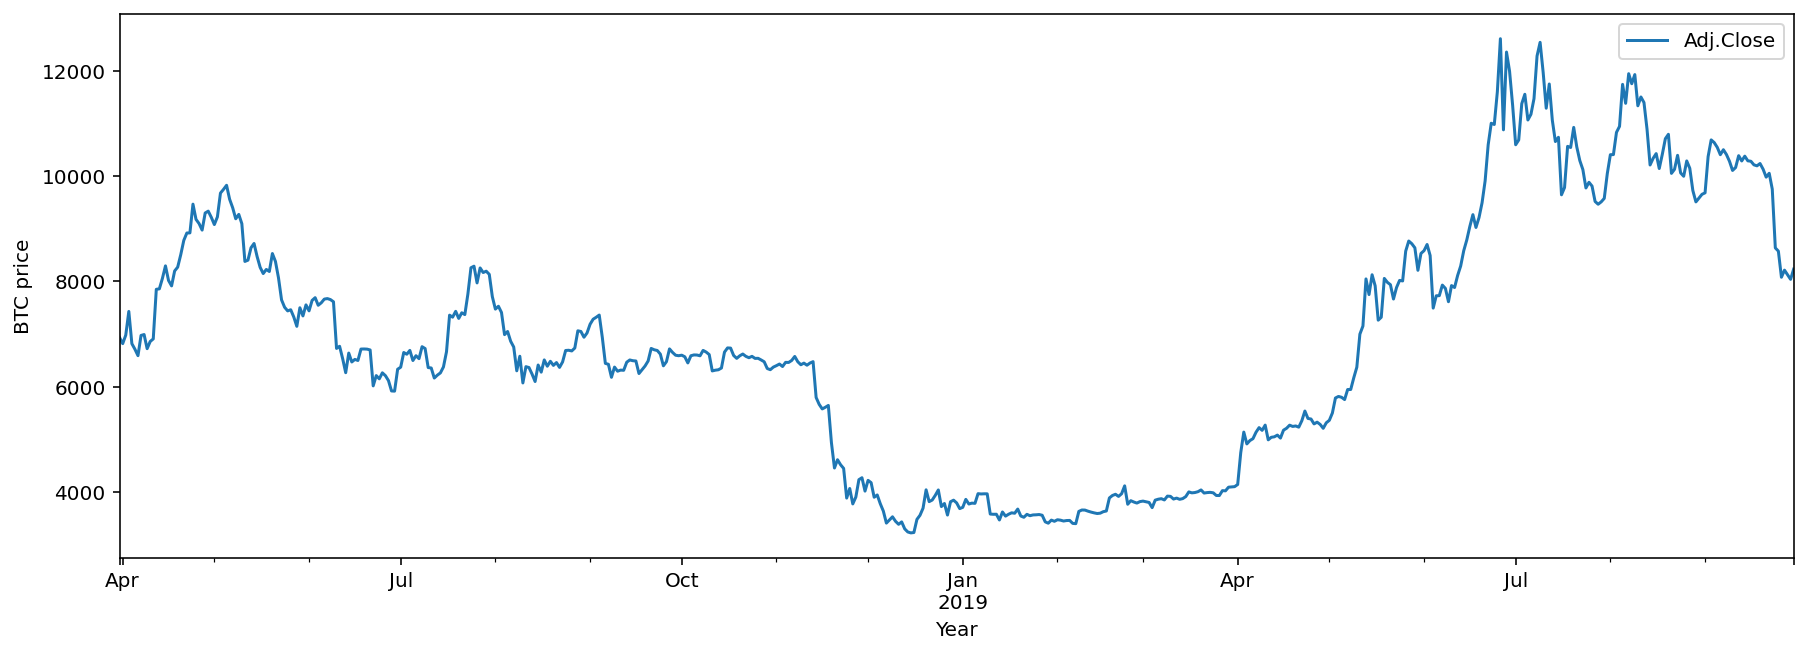

In [25]:
btc.plot(figsize=(15,5))
plt.xlabel('Year')
plt.ylabel('BTC price')

In [26]:
btc['returns']     = btc['Adj.Close'].pct_change()
btc['log_returns'] = np.log(btc['Adj.Close']).diff()
returnseries       = np.log(rt['Adj.Close']).diff()
btc = btc.dropna()

#btc

In [27]:
interval = 365
windows = [btc['log_returns'][slice(i,i+interval)]for i in range(len(btc)-interval)]

## GARCH

In [35]:
rows = []
tmp  = []

for window in windows:
    garch = arch.arch_model(window - window.mean(), mean="Zero", rescale=False)
    res   = garch.fit(disp="off")
    #print(res.summary())
    alpha0=res.params[0]
    alpha1=res.params[1]
    beta=res.params[2]
    volest = alpha0 + (alpha1 * window[-1]**2 + beta * res.conditional_volatility[-1]**2)
    forecast_date = window.index[-1]
    rows.append([forecast_date, np.sqrt(volest)])
    
df = pd.DataFrame(rows, columns=['date', 'vol']).set_index('date')
garchvol = df['vol'].to_list()

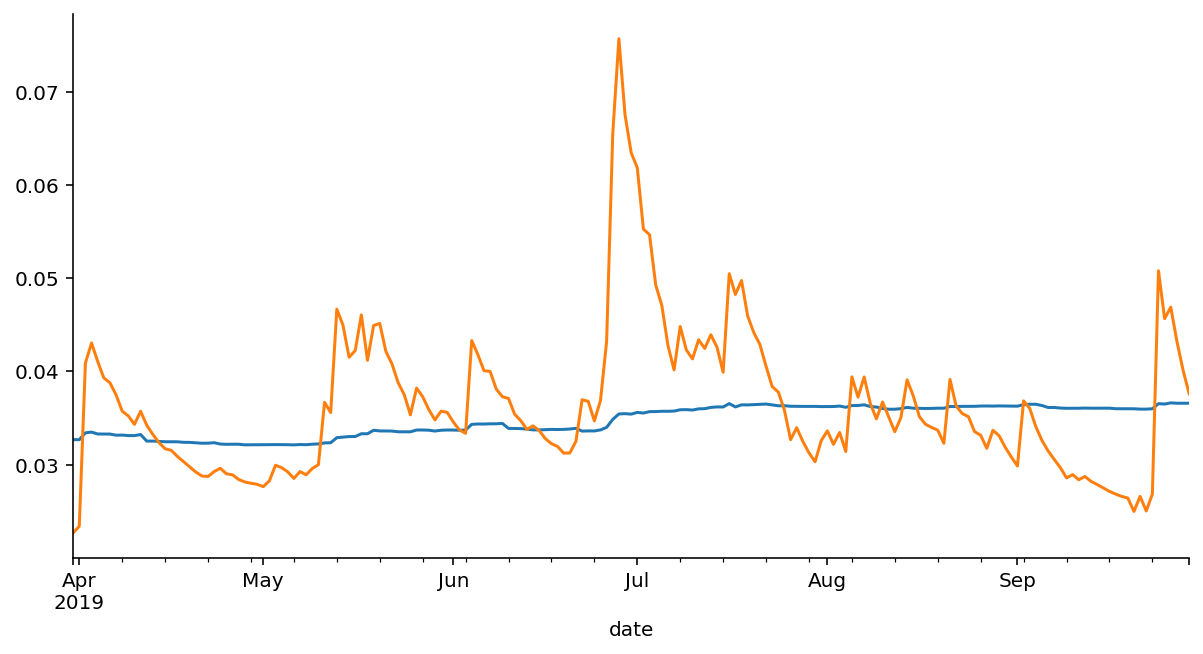

In [36]:
df['rollingstd'] = np.std(windows, axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
df['rollingstd'].plot(ax=ax, label="Std")
df['vol'].plot(ax=ax, label="Forecast")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')



fig.savefig('volestimate.png',transparent=True)

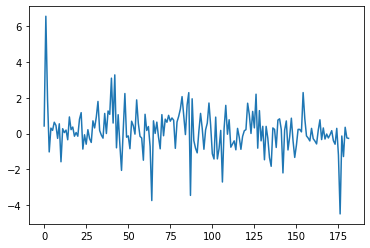

In [9]:
returnseries = list(returnseries.dropna())
del returnseries[-1]
degarched = [x/y for x,y in zip(returnseries,garchvol)]
plt.plot(degarched)


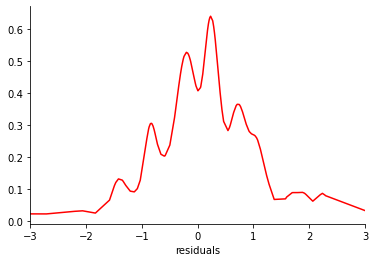

In [10]:
kde_non_resampled = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.array(degarched).reshape(-1, 1))
log_dens = kde_non_resampled.score_samples(np.array(degarched).reshape(-1, 1))
density = np.exp(log_dens)
fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
#ax.hist(np.array(degarched), bins=200, density=True, color = "black") #d1edf2
samples = kde_non_resampled.sample(20000).T[0]
#ax.hist(samples, bins=200, density=True, alpha=0.7, color="darkgrey") 
df = pd.DataFrame(np.array([np.array(degarched).reshape(-1, 1).T[0], density]).T, columns=['x', 'density']).set_index('x').sort_index()
df['density'].plot(ax=ax, c='r')
ax.set_xlabel("residuals")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


fig.savefig('hd_kde.png',transparent=True)

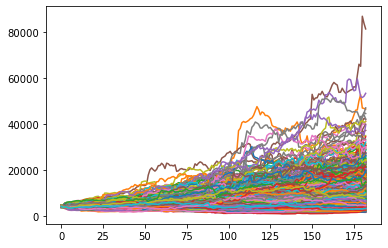

In [11]:
def path():
    spot = rt["Adj.Close"].iloc[0]
    return spot * np.exp(np.cumsum(garchvol * kde_non_resampled.sample(len(garchvol)).T[0]))

paths = np.array([path() for _ in range(1000)])
plt.plot(paths.T)
plt.savefig('scenarios_kde.png',transparent=True)

## Scenario generation

In [12]:
dt = 1 / 365
n = 100000
m = len(btc)

In [13]:
T = len(btc) / 365
t = np.arange(0, T + dt, dt)

In [14]:
s = np.zeros([n, m])

In [15]:
s0     = 4500
s[:,0] = s0 
k      = s0
r = 0

In [16]:
s = np.array([path() for _ in range(n)])
s.shape

(100000, 183)

## Monte Carlo price

In [17]:
cp = np.exp(-r * T) * np.maximum(s[:,-1]-k,0).mean()
cp

7120.658892042583

In [18]:
#greeks

def deltafunc(S, K, T, sigma, r):
    d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
    return scs.norm.cdf(d1) 

In [19]:
deltabs         = np.zeros([n, m+1])
ttm             = T - np.arange(1, m+1, 1)/m
r = 0
# Hedging 
deltabs[:,0]    = deltafunc(s0, k, T, sigmas.iloc[0], r)

<ipython-input-18-e07676b8d53e>:4: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
<ipython-input-18-e07676b8d53e>:4: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))


In [20]:
# Hedging 


for i in range(1, len(sigmas)):
    deltabs[:,i] = deltafunc(s[:,i], k, T-ttm[i], sigmas.iloc[0], r)

<ipython-input-18-e07676b8d53e>:4: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))
<ipython-input-18-e07676b8d53e>:4: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  d1 = (sp.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * sp.sqrt(T))


In [21]:
Pnl = cp

for i in range(1,  len(sigmas)):
    Pnl -= np.exp(r * dt) * ((deltabs[:,i]-deltabs[:,i-1]) * s[:,i])
    
PayoffCheck      = [k if sT < k else 0 for sT in s[:,-1]]
PnL_final        = [Pnl[i] - PayoffCheck[i] for i in range(len(Pnl))]

#delta_final      = [deltabs[i,-1] - 1 if PayoffCheck[i] == k else deltabs[i,-1] for i in range(len(deltabs[:,-1]))]
# PnL_final        = PnL_final + delta_final * s[:,-1]

PnL_final        = PnL_final/cp

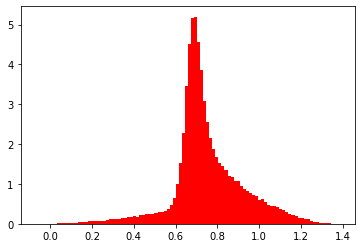

In [22]:
fig = plt.hist(PnL_final, bins=100, density=True,color='red')
#os.makedirs(os.path.dirname(hedge), exist_ok=True)
plt.savefig('bs_hedge.png', transparent=T)